## Spatial Matched Field Processing

### Here, MFP is implemented as a gridsearch over possible sources in the spatial domain. This uses straight rays and a constant velocity, but more sophisticated implementations are possible.

### Note that the 3rd cell will recreate synthetic seismograms using the GI package, or it can reload data from file depending on the flag "use_saved_data"

In [1]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = [20, 10]

In [3]:
use_saved_data = True

#####################################################
if(use_saved_data is False):
    
    # Check the station and noise-source geometry
    S,indeces=s.space_distribution(plot=1)


    # Re-create the synthetic data.
    ut,traw,cct,t,ccf,f = generate_random_signals(verbose=False,plot=False,save=True,return_cc=True)
#####################################################
else:
    # Alternatively, just load from file
    p=parameters.Parameters()

    # Load "traw" of raw timeseries
    filename = './OUTPUT/raw_synthetics/traw.npy'
    traw = np.load(filename)
    
    # Load raw timeseries
    for i in range(p.Nreceivers):
        filename = './OUTPUT/raw_synthetics/syn_{0}.npy'.format(i)
        if(i==0): # first one, load to get size.
            tmp = np.load(filename)
            [nsamp,nwindows] = np.shape(tmp)
            ut = np.zeros([nsamp,nwindows,p.Nreceivers])
            ut[:,:,i] = tmp
        else:
            ut[:,:,i] = np.load(filename)
    
    # Load "t" of correlations functions
    filename = './OUTPUT/correlations_measured/t.npy'
    tt_corr = np.load(filename)
    nt = np.size(tt_corr)

    # Load correlation functions
    cct = np.zeros([nt,p.Nwindows,p.Nreceivers**2])
    counter = 0
    for i in range(p.Nreceivers):
        for j in range(p.Nreceivers):        
            filename = "./OUTPUT/correlations_measured/cct_proc_{}_{}.npy".format(i,j)
            this_corr = np.load(filename)

            cct[:,:,counter] = this_corr
            counter += 1
#####################################################
            
# "Data" will consist of raw timeseries from just the first time window (only one by default)
iwin=0
data=ut[:,iwin,:]


# Ideally one might stack correlations from multiple time windows if they existed, 
#  but default parameters is to have only one anyways.
iwin=0
correlations = cct[:,iwin,:]


starting gridpoints: 14400
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


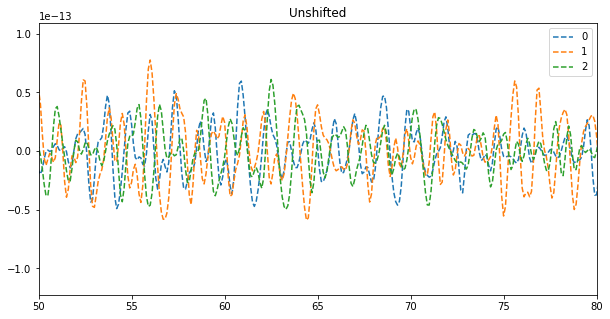

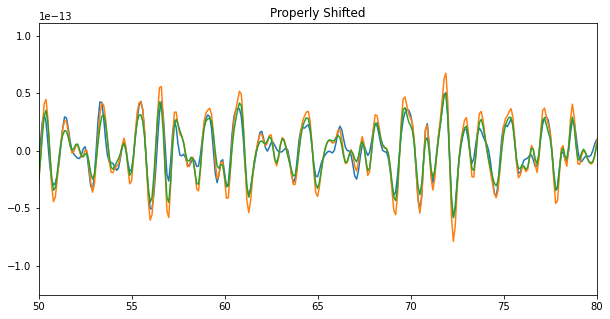

11000
12000
13000
14000


In [4]:
#MFP!

downsample=5
# Note that I'm downsampling the spatial grid here to make this computationally faster.
#  To be a proper comparison to the noise-source inversion result, this should be set to
#  downsample=1 (i.e., no downsamping)

plot=True 
# The final MFP result is plotted in a different cell below.
# Since this is a synthetic setup, we *know* where the correct source is
#  and will plot the time-shifted traces for this correct source

# This uses time domain shifts. This is rather slow, because it uses the fft-domain,
#  specshift function. This could be simplified or made faster with direct shifts.
#  Also, probably most production-quality MFP codes operate in frequency domain anyways.

#- Input parameters.
p=parameters.Parameters()
xx = p.x/1000
yy = p.y/1000

# Here, we have to assume a constant velocity!
# (You could use raytracing on a more sophisticated velocity model, but ours is homogeneous anyways.
#   Regardless, the point remains that you *must* have some velocity information beforehand.)
rvel=3.0       

# Spatial grid.
# Here we go 50% beyond the computation border, to see what happens at greater distances
x_line=np.arange(p.xmin*1.5,p.xmax*1.5,p.dx*downsample)/1000.0
y_line=np.arange(p.ymin*1.5,p.ymax*1.5,p.dy*downsample)/1000.0
x,y=np.meshgrid(x_line,y_line)


# We know where the source actually is. Define it for plotting later:
x0=0.75*p.xmax
y0=0.75*p.ymax
ix0=(np.abs(x_line*1000.0-x0)).argmin()
iy0=(np.abs(y_line*1000.0-y0)).argmin()


P=np.zeros([np.size(x_line),np.size(y_line)],dtype=complex)

print("starting gridpoints: {0}".format(np.size(x_line)*np.size(y_line)))
counter_grid=0
for idx in range(len(x_line)):
        for idy in range(len(y_line)):
            counter_grid+=1
            if(counter_grid % 1000 == 0):
                print(counter_grid)
                 
            distances = np.sqrt( (xx-x_line[idx])**2 + (yy-y_line[idy])**2 )
            timeshifts = distances / rvel
            
            dshift = specshift(data,timeshifts/p.dt)
            A = np.corrcoef(dshift.T)
    
            np.fill_diagonal(A,0) # Exclude autocorrelations
            P[idx,idy] = np.sum( A ) / (np.size(A)-np.shape(A)[0])

            if(plot):
                if(idx==ix0 and idy==iy0): # Only the slowness pixel that we know is correct.

                    plt.figure(figsize=(10,5))
                    plt.plot(traw,data,'--')
                    ax=plt.gca()
                    ax.set_xlim([50,80])
                    plt.legend(['0','1','2'])
                    plt.title('Unshifted')
                    plt.show()                

                    plt.figure(figsize=(10,5))
                    plt.plot(traw,dshift)
                    ax=plt.gca()
                    ax.set_xlim([50,80])
                    plt.title('Properly Shifted')
                    plt.show()

                    

np.save('3_P_MFP', P)


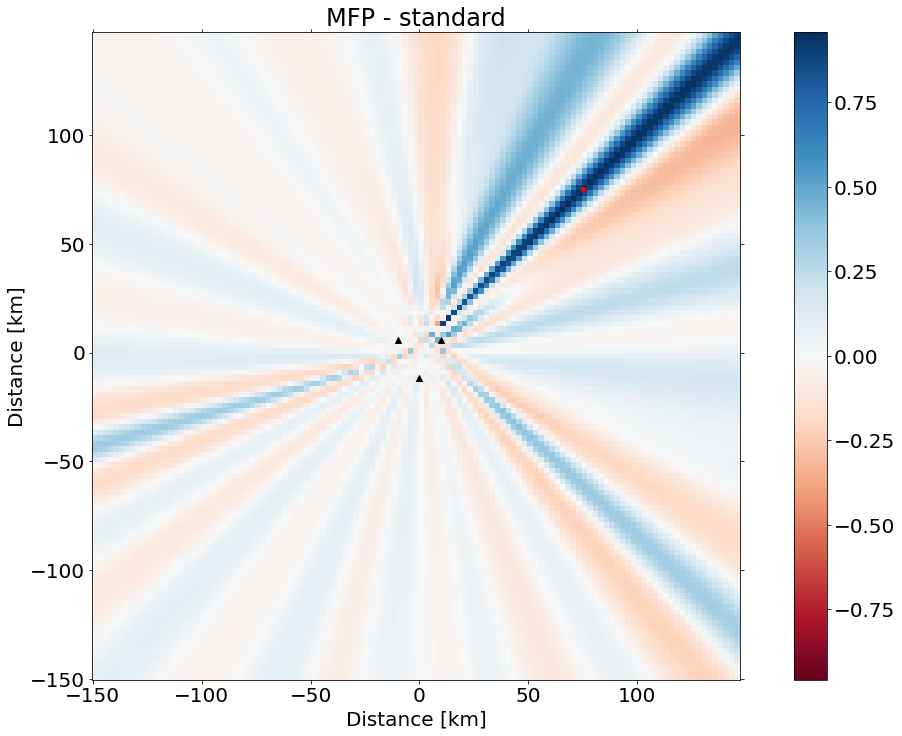

In [5]:
mpl.rc('font', **{'size':20})

def plot_P(P,title="MFP",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])
    cmap = plt.get_cmap('RdBu')
    i = plt.pcolor(x_line-p.dx/1000/2,y_line-p.dy/1000/2,np.real(P.T),cmap='RdBu',rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(np.real(P))
    plt.clim(-cmax,cmax)
    plt.xlabel('Distance [km]')
    plt.ylabel('Distance [km]')
    plt.plot(x0/1000.0,y0/1000.0,'r*')
    plt.plot(xx,yy,'k^')
    plt.title(title)
    plt.axis('equal')
    ax.tick_params(top=True,right=True)

    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])
    fig.colorbar(i, cax=colorbar_ax)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

plot_P(P,title="MFP - standard",save=False,savename="3_MFP.pdf")



### We see that there is a strong beam/swath to the NorthEast, exactly where our source is. We have not given the MFP algorithm any information about amplitude decay with distance, so we can't distinguish how far away the source is, only that it would lie somewhere along this region.
### Note that this pattern is a sum of multiple hyperbola. A two-station case gives hyperbolas out to either side, and summing these together for our 3 station pairs gives the pattern above.